In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

from SNNComponents import SpikingNeuronLayerRNN
from SNNComponents import OutputDataToSpikingPerceptronLayer
from SNNComponents import InputDataToSpikingPerceptronLayer

from util import test, train, train_many_epochs, train_epochs

In [2]:
from data_reader import load_train_test_sets

batch_size = 1000
training_set, testing_set = load_train_test_sets()
train_set_loader = torch.utils.data.DataLoader(
    dataset = training_set,
    batch_size=batch_size,
    shuffle=True)

test_set_loader = torch.utils.data.DataLoader(
    dataset=testing_set,
    batch_size=1,
    shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

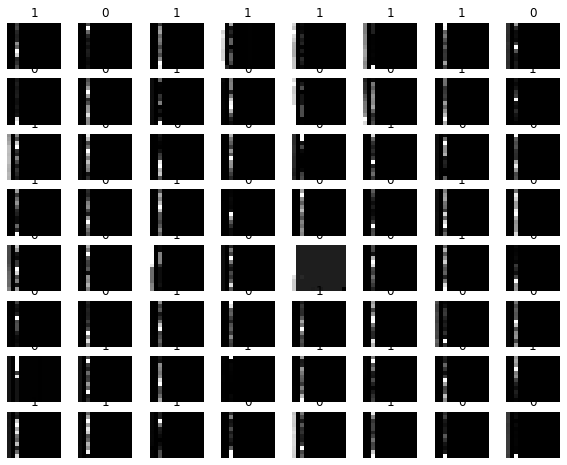

In [3]:
import matplotlib.pyplot as plt
figure = plt.figure(figsize=(10, 8))
cols, rows = 8, 8
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_set), size=(1,)).item()
    img, label = training_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [97]:
class VietNetSNN(nn.Module):
    def __init__(self, device, n_time_steps, begin_eval):
        super(VietNetSNN, self).__init__()
        assert(0 <= begin_eval and begin_eval < n_time_steps)
        self.device = device
        self.n_time_steps = n_time_steps
        self.begin_eval = begin_eval
        
        self.input_conversion = InputDataToSpikingPerceptronLayer(device)
        
        self.layer1 = SpikingNeuronLayerRNN(
            device, n_inputs=12*14, n_hidden=256, decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5)
        self.layer2 = SpikingNeuronLayerRNN(
            device, n_inputs=256, n_hidden=128, decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.25)
        self.layer3 = SpikingNeuronLayerRNN(
            device, n_inputs=128, n_hidden=2, decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5)
        
        self.all_layers = [self.layer1, self.layer2, self.layer3]
        
        self.output_conversion = OutputDataToSpikingPerceptronLayer(average_output=False)
        self.to(device)
        
    def forward_through_time(self, x):
        self.input_conversion.reset_state()
        for layer in self.all_layers:
            layer.reset_state()
        out = []
        all_states = []
        all_outputs = []
        
        for _ in range(self.n_time_steps):
            xi = self.input_conversion(x)
            prev_layer_state, prev_layer_output = None, xi
            for layer in self.all_layers:
                layer_state, layer_output = layer(prev_layer_output)
                prev_layer_state, prev_layer_output = layer_state, layer_output

                all_states.append(layer_state)
                all_outputs.append(layer_output)

            out.append(prev_layer_state)
        out = self.output_conversion(out[self.begin_eval:])
        return out, [[layer_states, layer_outputs] 
                     for layer_states, layer_outputs in zip(all_states, all_outputs)]
        
    def forward(self, x):
        out, _ = self.forward_through_time(x)
        return F.log_softmax(out, dim=-1)

In [69]:
class VietNetSNN(nn.Module):
    def __init__(self, device, n_time_steps, begin_eval):
        super(VietNetSNN, self).__init__()
        assert( 0 <= begin_eval and begin_eval < n_time_steps)
        self.deice = device
        self.n_time_steps = n_time_steps
        self.begin_eval = begin_eval

        self.input_conversion = InputDataToSpikingPerceptronLayer(device)

        self.layer1 = SpikingNeuronLayerRNN(
            device, n_inputs=12*14, n_hidden=100, decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5)

        self.layer2 = SpikingNeuronLayerRNN(
            device, n_inputs=100, n_hidden=2, decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5)

        self.all_layers = [self.layer1, self.layer2]

        self.output_conversion = OutputDataToSpikingPerceptronLayer(average_output=False)

        self.to(device)

    def forward_through_time(self, x):
        self.input_conversion.reset_state()
        for layer in self.all_layers:
            layer.reset_state()

        out = []
        
        all_states = []
        all_outputs = []

        for _ in range(self.n_time_steps):
            xi = self.input_conversion(x)
            prev_layer_state, prev_layer_output = None, xi
            for layer in self.all_layers:
                layer_state, layer_output = layer(prev_layer_output)
                prev_layer_state, prev_layer_output = layer_state, layer_output

                all_states.append(layer_state)
                all_outputs.append(layer_output)

            out.append(prev_layer_state)
        out = self.output_conversion(out[self.begin_eval:])
        return out, [[layer_states, layer_outputs] 
                     for layer_states, layer_outputs in zip(all_states, all_outputs)]

    def _DEP_forward_through_time(self, x):
        self.input_conversion.reset_state()
        self.layer1.reset_state()
        self.layer2.reset_state()

        out = []

        all_layer1_states = []
        all_layer1_outputs = []

        all_layer2_states = []
        all_layer2_outputs = []

        for _ in range(self.n_time_steps):
            xi = self.input_conversion(x)

            layer1_state, layer1_output = self.layer1(xi)
            layer2_state, layer2_output = self.layer2(layer1_output)

            all_layer1_states.append(layer1_state)
            all_layer1_outputs.append(layer1_output)

            all_layer2_states.append(layer2_state)
            all_layer2_outputs.append(layer2_output)
            out.append(layer2_state)

        out = self.output_conversion(out[self.begin_eval:])
        return out, [[all_layer1_states, all_layer1_outputs],
                     [all_layer2_states, all_layer2_outputs]]


    def forward(self, x):
        out, _ = self.forward_through_time(x)
        return F.log_softmax(out, dim=-1)


In [98]:
class VietNetCNN(nn.Module):
    def __init__(self):
        super(VietNetCNN, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1,
                     out_channels=16,
                     kernel_size=5,
                     stride=1,
                     padding=2,
                ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        
        self.fc1 = nn.Linear(288, 512)
        self.fc2 = nn.Linear(512, 64)
        self.out = nn.Linear(64, 1)
        
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        out = self.sigmoid(self.out(x))
        return out, x

In [99]:
loss_func = nn.BCELoss()
cnn = VietNetCNN()
optimizer = optim.Adam(cnn.parameters(), lr=0.01)

In [100]:
from torch.autograd import Variable
num_epochs = 20

def train(num_epochs, cnn, train_loader, test_loader):
    cnn.train()
    
    total_steps = len(train_loader)
    
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            b_x = Variable(images)
            b_y = Variable(labels)
            
            raw_out = cnn(b_x)
            output = raw_out[0].reshape(b_y.shape)

            b_y = b_y.float()
            loss = loss_func(output, b_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_steps}], loss: {loss.item():.4f}')
            if (i+1) % 100 == 0: 
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_steps}], loss: {loss.item():.4f}')
                
def test(test_loader):
    cnn.eval()
    
    with torch.no_grad():
        correct = 0
        total = 0
        for image, labels in test_loader:
            test_output, last_layer = cnn(images)
            pred_y = torch.round(test_output, 1)

In [101]:
def train(model, device, train_set_loader, optimizer, epoch, logging_interval=100):
    model.train()
    for batch_idx, (data, target) in enumerate(train_set_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        
        output = model(data)
        #print(output)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % logging_interval == 0:
            pred = output.max(1, keepdim=True)[1]
            correct = pred.eq(target.view_as(pred)).float().mean().item()
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)] Loss: {:.6f} Accuracy: {:.2f}%'.format(
                epoch, batch_idx * len(data), len(train_set_loader.dataset),
                100. * batch_idx / len(train_set_loader), loss.item(),
                100. * correct))
            

def test(model, device, test_set_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_set_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            print(output)
            
            test_loss += F.nll_loss(output, target, reduce=True).item()
            pred = output.max(1, keepdim=True)[1]
            print(pred)
            correct += pred.eq(target.view_as(pred)).sum().item()
            
    test_loss /= len(test_set_loader.dataset)
    print()
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        test_loss,
        correct, len(test_set_loader.dataset),
        100. * correct / len(test_set_loader.dataset)))
    print("")
    
def train_epochs(model, device, train_set_loader, test_set_loader, epochs, lr=0.1, lr_decay=0.5, momentum=0.5):
    for e in range(1, epochs+1):
        optimizer = optim.SGD(model.parameters(), lr=lr* (e * lr_decay), momentum=momentum)
        train(model, device, train_set_loader, optimizer, e, logging_interval=10)
        test(model, device, test_set_loader)

In [102]:
spiking_model = VietNetSNN(device, n_time_steps = 128, begin_eval=0)
train_epochs(spiking_model, device, train_set_loader, train_set_loader, 10)

Train Epoch: 1 [0/49417 (0%)] Loss: 818483.312500 Accuracy: 50.50%
Train Epoch: 1 [10000/49417 (20%)] Loss: nan Accuracy: 55.00%
Train Epoch: 1 [20000/49417 (40%)] Loss: nan Accuracy: 54.40%


KeyboardInterrupt: 